In [18]:
import sys, subprocess, time, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_aer.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.optimizers import COBYLA

In [2]:
# ===== Parametry do łatwej zmiany =====
data_path   = "countsAll_fixed_07_07_23.csv"  # ścieżka do pliku z danymi
sep         = "\t"                            # separator (w Twoim pliku jest tab)
n_components_pca = 4                          # liczba komponentów PCA = liczba kubitów
test_size   = 0.20                            # ułamek danych do testu
random_state = 42                             # ziarno losowe
maxiter     = 10                          # iteracje optymalizatora
entanglement = "linear"                       # "linear" | "full" | lista par
reps_feature = 2                              # głębokość feature map
reps_ansatz  = 2  

In [3]:
# ===== 1) Wczytanie i przygotowanie danych =====
print("Wczytywanie danych...")
df = pd.read_csv(data_path, sep=sep)
df

Wczytywanie danych...


,Vumc-HD-101-TR922,Vumc-HD-103-TR923,Vumc-HD-108-TR924,Vumc-HD-127-TR925,Vumc-HD-130-TR926,Vumc-HD-142-TR927,Vumc-HD-143-TR928,Vumc-HD-144-TR929,Vumc-HD-145-TR930,Vumc-HD-149-TR932,...,NKI-4854-SARC-TR3080,NKI-4707-SARC-TR3079,NKI-4941-SARC-TR3084,NKI-6348-SARC-TR3134,NKI-5275-SARC-TR3099,NKI-5148-SARC-TR3129,Vumc-P-PH-001-010-TR1505,Vumc-P-PH-001-034-TR1512,P-PH-001-013-TR1400,NKI-NSCLC-107-270-TR725
ENSG00000000419,3.632451,5.424969,5.611568,6.767679,5.966390,4.028501,3.083092,3.083092,4.139867,4.727528,...,5.766644,3.083092,4.546419,3.931063,5.085920,6.190901,5.819020,5.765332,3.083092,4.492600
ENSG00000000460,3.775522,3.995549,4.717973,4.591289,3.931296,3.859498,4.456780,5.053551,3.648963,3.937986,...,3.083092,4.980725,3.083092,3.931063,7.232445,4.629435,4.221945,3.083092,4.067054,3.083092
ENSG00000000938,4.260973,7.067806,7.707506,5.868780,6.253597,4.345543,4.600318,4.235676,4.167549,4.923042,...,6.905074,8.077880,4.546419,4.618885,8.504650,8.400287,6.665398,7.275455,6.196317,6.428612
ENSG00000001036,4.543570,4.941661,4.484228,5.367115,4.745940,4.801515,4.506743,4.702331,4.914034,3.808559,...,4.768223,4.980725,5.743517,5.234088,4.298299,5.185196,5.058724,4.870939,4.729742,3.083092
ENSG00000001461,5.029391,4.259827,4.294742,4.310781,4.514088,4.496055,3.715812,3.877052,4.768445,4.425196,...,4.768223,4.229033,3.083092,3.083092,5.346590,4.364454,4.656650,4.653690,4.067054,3.083092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000266356,5.086967,5.387720,5.205304,5.608233,5.508326,5.434903,5.965926,6.011843,5.708351,5.746547,...,4.768223,4.980725,5.452343,5.507768,4.473684,5.026135,5.429115,5.215962,5.145922,3.083092
ENSG00000266714,3.684170,5.869712,6.689908,6.922877,4.266525,3.083092,3.367864,3.083092,4.081793,3.808559,...,7.053600,8.559626,6.366710,5.507768,8.016687,7.142846,6.234742,6.229989,6.422278,6.697497
ENSG00000269028,7.911457,7.238790,7.273774,7.917768,8.425523,7.863294,8.328570,8.268792,7.590476,8.517492,...,3.083092,4.229033,3.083092,5.350424,3.083092,4.844002,7.057266,7.438265,6.617061,9.450368
ENSG00000271043,6.687347,5.963607,6.189792,6.304293,6.674708,6.613601,6.539577,6.724614,6.033518,6.826289,...,3.083092,3.083092,3.083092,4.397320,3.083092,4.364454,5.610055,6.193585,6.733502,7.767796


In [4]:
df = df.T
df

,ENSG00000000419,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001461,ENSG00000001497,ENSG00000001629,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000257267,ENSG00000257923,ENSG00000258890,ENSG00000263563,ENSG00000264538,ENSG00000266356,ENSG00000266714,ENSG00000269028,ENSG00000271043,ENSG00000272168
Vumc-HD-101-TR922,3.632451,3.775522,4.260973,4.543570,5.029391,3.855448,4.628870,4.349890,4.753364,4.969059,...,6.910770,8.159009,4.023624,4.677134,4.677134,5.086967,3.684170,7.911457,6.687347,4.753364
Vumc-HD-103-TR923,5.424969,3.995549,7.067806,4.941661,4.259827,4.829900,4.353655,5.597112,4.849252,5.680688,...,6.226170,6.521378,5.553313,4.769902,4.292098,5.387720,5.869712,7.238790,5.963607,4.353655
Vumc-HD-108-TR924,5.611568,4.717973,7.707506,4.484228,4.294742,4.345481,6.142851,5.156844,4.484228,6.166518,...,5.978413,7.367604,5.205304,4.819214,4.241258,5.205304,6.689908,7.273774,6.189792,4.294742
Vumc-HD-127-TR925,6.767679,4.591289,5.868780,5.367115,4.310781,4.540721,4.730747,5.468816,5.072008,5.493076,...,6.356788,5.831772,5.651689,4.968402,5.038411,5.608233,6.922877,7.917768,6.304293,5.227911
Vumc-HD-130-TR926,5.966390,3.931296,6.253597,4.745940,4.514088,4.114825,4.476669,5.332266,5.061243,6.133154,...,6.987751,5.893660,5.603847,4.913675,4.312167,5.508326,4.266525,8.425523,6.674708,5.588388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NKI-5148-SARC-TR3129,6.190901,4.629435,8.400287,5.185196,4.364454,6.260569,5.871313,5.871313,4.629435,6.390351,...,6.117595,7.178944,6.618873,5.185196,5.871313,5.026135,7.142846,4.844002,4.364454,4.003537
Vumc-P-PH-001-010-TR1505,5.819020,4.221945,6.665398,5.058724,4.656650,3.083092,5.552397,4.530363,4.387636,6.435525,...,6.583495,6.767748,5.819020,4.221945,4.387636,5.429115,6.234742,7.057266,5.610055,5.429115
Vumc-P-PH-001-034-TR1512,5.765332,3.083092,7.275455,4.870939,4.653690,4.018835,5.488100,4.527603,5.055182,6.606315,...,5.952725,7.861776,5.995866,4.767279,5.425116,5.215962,6.229989,7.438265,6.193585,4.653690
P-PH-001-013-TR1400,3.083092,4.067054,6.196317,4.729742,4.067054,4.450043,5.145922,4.955231,4.450043,3.083092,...,5.824065,7.679952,3.083092,4.729742,3.083092,5.145922,6.422278,6.617061,6.733502,5.824065


In [6]:
metadata = pd.read_csv("SampleInfo_fixed_08_07_23.csv", delimiter=";")
metadata = metadata.set_index("id")
metadata["label"] = metadata["GroupAlternative"].apply(
    lambda x: 0 if x == "Asymptomatic controls" else 1
)
metadata = metadata[metadata["RealLocation"] != "Institute 5"]
df = df.merge(metadata, left_index=True, right_index=True)

In [7]:
X = df.drop(columns=metadata.columns)
y = df["label"]

In [8]:
print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("Class balance:\n", y.value_counts())
print(f"Liczba cech (genów): {X.shape[1]}, liczba próbek: {X.shape[0]}")
print(f"Klasy: 0 (zdrowe) = {(y==0).sum()}, 1 (nowotworowe) = {(y==1).sum()}")

Shape X: (2060, 5346)
Shape y: (2060,)
Class balance:
 label
1    1706
0     354
Name: count, dtype: int64
Liczba cech (genów): 5346, liczba próbek: 2060
Klasy: 0 (zdrowe) = 354, 1 (nowotworowe) = 1706


In [9]:
# ===== 2) Podział na zbiory uczący i testowy =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)

In [10]:
# ===== 3) Standaryzacja + PCA (dopasowana na zbiorze uczącym) =====
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

pca = PCA(n_components=n_components_pca, random_state=random_state)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca  = pca.transform(X_test_std)

print(f"Po PCA: X_train = {X_train_pca.shape}, X_test = {X_test_pca.shape}")

Po PCA: X_train = (1648, 4), X_test = (412, 4)


In [11]:
# ===== 4) Budowa VQC =====
feature_map = ZZFeatureMap(feature_dimension=n_components_pca, reps=reps_feature)
ansatz      = TwoLocal(
    n_components_pca,
    rotation_blocks=["ry", "rz"],
    entanglement_blocks="cz",
    entanglement=entanglement,
    reps=reps_ansatz,
)

optimizer = COBYLA(maxiter=maxiter)

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
)

In [12]:
# ===== 5) Trening =====
print("\nTrening VQC...")
X_train_vqc = X_train_pca
X_test_vqc = X_test_pca
y_train_vqc = y_train.to_numpy()
y_test_vqc = y_test.to_numpy()
t0 = time.time()
vqc.fit(X_train_vqc, y_train_vqc)
t_vqc = time.time() - t0


Trening VQC...


In [14]:
# ===== Ewaluacja na TRAIN =====
y_pred_train = vqc.predict(X_train_pca)

acc_train = accuracy_score(y_train, y_pred_train)
bal_acc_train = balanced_accuracy_score(y_train, y_pred_train)
sens_train = recall_score(y_train, y_pred_train, pos_label=1)  # TPR
spec_train = recall_score(y_train, y_pred_train, pos_label=0)  # TNR

try:
    y_score_train = vqc.predict_proba(X_train_pca)[:, 1]
    auc_train = roc_auc_score(y_train, y_score_train)
except Exception:
    auc_train = roc_auc_score(y_train, y_pred_train)

In [15]:
# ===== Ewaluacja na TEST =====
y_pred_test = vqc.predict(X_test_pca)

acc_test = accuracy_score(y_test, y_pred_test)
bal_acc_test = balanced_accuracy_score(y_test, y_pred_test)
sens_test = recall_score(y_test, y_pred_test, pos_label=1)
spec_test = recall_score(y_test, y_pred_test, pos_label=0)

try:
    y_score_test = vqc.predict_proba(X_test_pca)[:, 1]
    auc_test = roc_auc_score(y_test, y_score_test)
except Exception:
    auc_test = roc_auc_score(y_test, y_pred_test)

In [16]:
print("\n=== Wyniki na TRAIN ===")
print(f"Accuracy:           {acc_train:.4f}")
print(f"Balanced accuracy:  {bal_acc_train:.4f}")
print(f"Sensitivity (TPR):  {sens_train:.4f}")
print(f"Specificity (TNR):  {spec_train:.4f}")
print(f"ROC AUC:            {auc_train:.4f}")
print("\n=== Wyniki na TEST ===")
print(f"Accuracy:           {acc_test:.4f}")
print(f"Balanced accuracy:  {bal_acc_test:.4f}")
print(f"Sensitivity (TPR):  {sens_test:.4f}")
print(f"Specificity (TNR):  {spec_test:.4f}")
print(f"ROC AUC:            {auc_test:.4f}")


=== Wyniki na TRAIN ===
Accuracy:           0.5576
Balanced accuracy:  0.4837
Sensitivity (TPR):  0.5963
Specificity (TNR):  0.3710
ROC AUC:            0.4688

=== Wyniki na TEST ===
Accuracy:           0.5194
Balanced accuracy:  0.4811
Sensitivity (TPR):  0.5396
Specificity (TNR):  0.4225
ROC AUC:            0.4715


In [17]:
# ===== 6) Ewaluacja =====
y_pred = vqc.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print("\n=== Wyniki ===")
print(f"Dokładność na zbiorze testowym: {acc:.4f}")
print(f"Czas wykonania (s): {t_vqc:.2f}")


=== Wyniki ===
Dokładność na zbiorze testowym: 0.5194
Czas wykonania (s): 102.13


In [19]:
# ===== ROC curve dla TRAIN =====
try:
    y_score_train = vqc.predict_proba(X_train_pca)[:, 1]
except Exception:
    # jeżeli nie ma predict_proba, bierzemy etykiety (to da schodkową krzywą)
    y_score_train = y_pred_train

fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)

# ===== ROC curve dla TEST =====
try:
    y_score_test = vqc.predict_proba(X_test_pca)[:, 1]
except Exception:
    y_score_test = y_pred_test

fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)

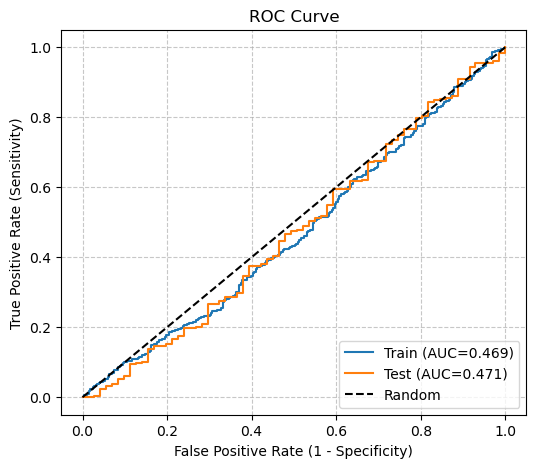

In [20]:
# ===== Rysowanie =====
plt.figure(figsize=(6, 5))
plt.plot(fpr_train, tpr_train, label=f"Train (AUC={auc_train:.3f})")
plt.plot(fpr_test, tpr_test, label=f"Test (AUC={auc_test:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()